In [1]:
import os
import pandas as pd
import numpy as np
import pywt
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Concatenate, TimeDistributed, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.losses import Huber

2024-11-14 13:41:53.532354: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731602513.546559   62795 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731602513.550881   62795 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 13:41:53.565191: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Carrega o dataset

In [2]:

data = pd.read_csv("dataset.csv")

# Converte a coluna 'id' para string e extrai a parte antes do ponto
data['id_str'] = data['id'].astype(str).apply(lambda x: x.split('.')[0]) 
data['id_datetime'] = pd.to_datetime(data['id_str'], errors='coerce') 

# Define 'id_datetime' como índice do dataframe
data.set_index('id_datetime', inplace=True)
data.drop(columns=['id_str'], inplace=True)

# Cria um novo dataframe 'variables' com o mesmo índice de 'data'
variables = pd.DataFrame(index=data.index)


#### Transformada de wavelet

In [3]:
def wavelet_denoising(signal, wavelet='bior2.2', level=3):
    """
    Realiza a denoising de um sinal utilizando transformada wavelet.
    
    :param signal: Sinal a ser denoizado.
    :param wavelet: Tipo de wavelet a ser utilizada.
    :param level: Nível de decomposição.
    :return: Sinal denoizado.
    """
    # Decompõe o sinal utilizando a wavelet especificada
    coeffs = pywt.wavedec(signal, wavelet, mode='periodization', level=level)
    
    # Estima o ruído
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    
    # Aplica thresholding suave nos coeficientes de detalhe
    coeffs[1:] = [pywt.threshold(i, value=uthresh, mode='soft') for i in coeffs[1:]]
    
    # Reconstrói o sinal a partir dos coeficientes denoizados
    reconstructed_signal = pywt.waverec(coeffs, wavelet, mode='periodization')
    
    # Retorna o sinal denoizado com o mesmo comprimento do original
    return reconstructed_signal[:len(signal)]

#### Filtragem e escolha de dado para o modelo

In [4]:

# Lista das colunas que serão denoizadas
columns_to_denoise = ['ws100', 'humid', 'wdisp100', 'temp', 'vertdisp100']

# Aplica a denoising wavelet em cada coluna especificada
for col in columns_to_denoise:
    if col in data.columns:
        denoised_signal = wavelet_denoising(data[col].values)
        variables[f'{col}_wavelet'] = denoised_signal  
    else:
        raise ValueError(f"A coluna '{col}' não existe no dataset.")

# Inicializa escaladores MinMax para normalizar os dados
scaler_ws100 = MinMaxScaler()
scaler_other = MinMaxScaler()

# Cria uma cópia dos dados denoizados para escalonamento
variables_scaled = variables.copy()

# Aplica o escalonamento na coluna 'ws100_wavelet'
variables_scaled[['ws100_wavelet']] = scaler_ws100.fit_transform(variables[['ws100_wavelet']])

# Aplica o escalonamento nas demais colunas denoizadas
variables_scaled[['humid_wavelet', 'wdisp100_wavelet', 'temp_wavelet', 'vertdisp100_wavelet']] = scaler_other.fit_transform(
    variables[['humid_wavelet', 'wdisp100_wavelet', 'temp_wavelet', 'vertdisp100_wavelet']]
)

print(f"Forma dos dados escalados: {variables_scaled.shape}")

Forma dos dados escalados: (7561, 5)


#### Matriz de correlação

Matriz de Correlação entre os Componentes de Tendência:
                     ws100_wavelet  humid_wavelet  wdisp100_wavelet  \
ws100_wavelet             1.000000      -0.449405          0.658290   
humid_wavelet            -0.449405       1.000000         -0.708133   
wdisp100_wavelet          0.658290      -0.708133          1.000000   
temp_wavelet              0.278794      -0.904602          0.608818   
vertdisp100_wavelet       0.419655      -0.842778          0.842502   

                     temp_wavelet  vertdisp100_wavelet  
ws100_wavelet            0.278794             0.419655  
humid_wavelet           -0.904602            -0.842778  
wdisp100_wavelet         0.608818             0.842502  
temp_wavelet             1.000000             0.860152  
vertdisp100_wavelet      0.860152             1.000000  


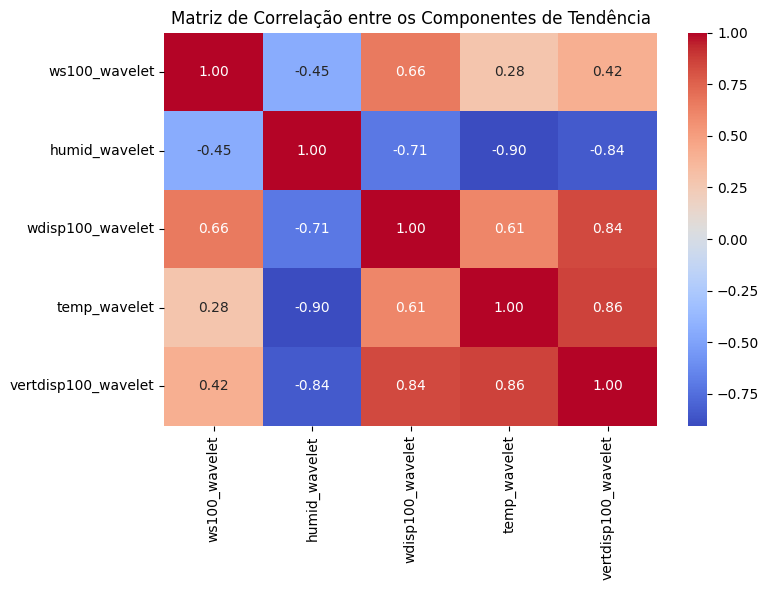

In [5]:
# Plotar ws100 original vs denoised
correlation_matrix = variables.corr()

print("Matriz de Correlação entre os Componentes de Tendência:")
print(correlation_matrix)

# Plotar a matriz de correlação
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação entre os Componentes de Tendência')
plt.tight_layout()
plt.show()

#### Comparação de curvas

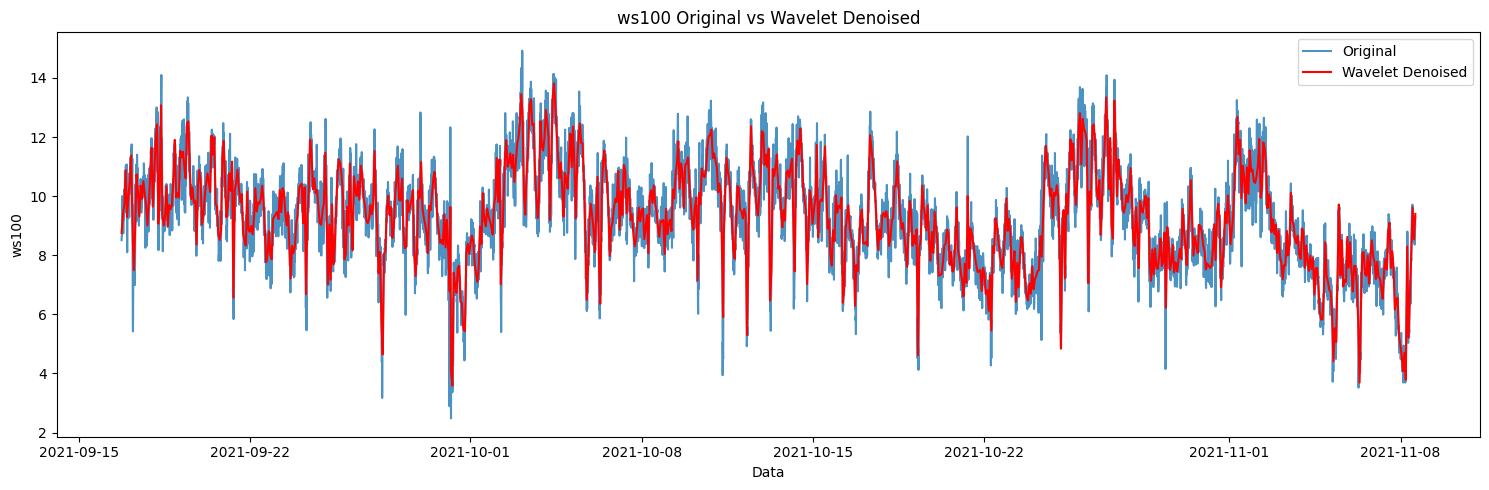

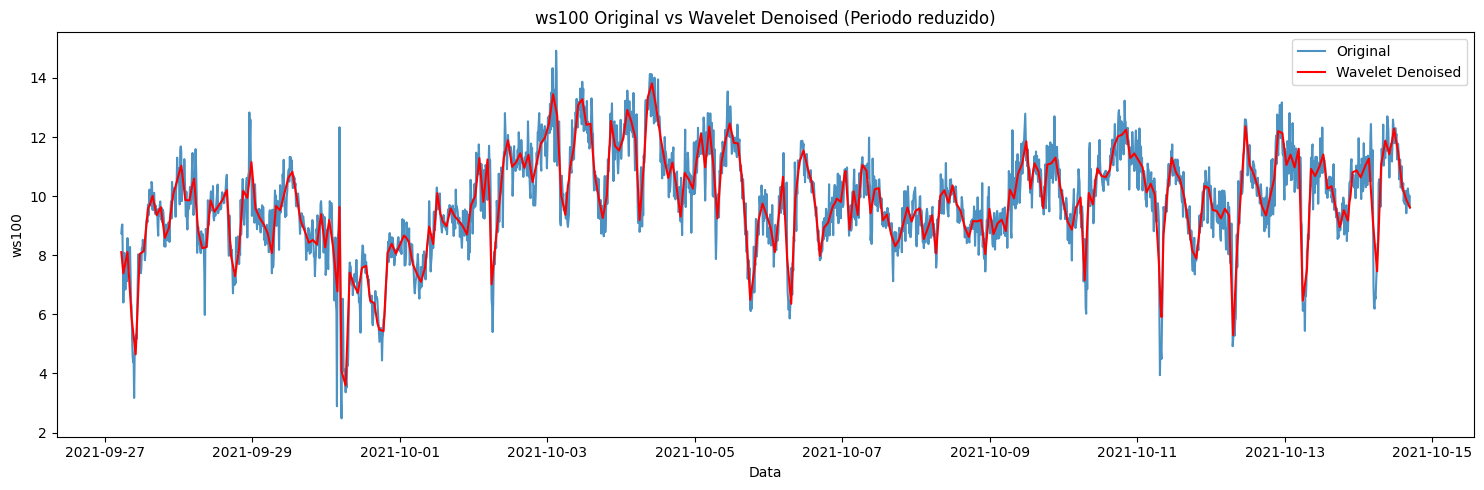

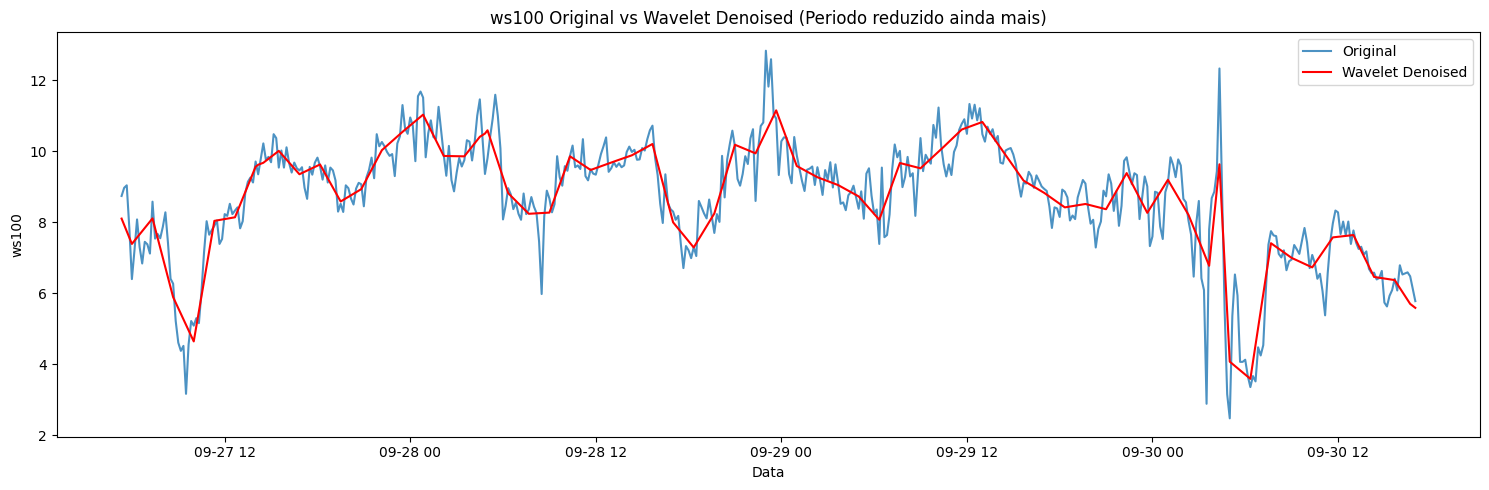

In [6]:

plt.figure(figsize=(15, 5))
plt.plot(data.index, data['ws100'], label='Original', alpha=0.8)
plt.plot(variables.index, variables['ws100_wavelet'], label='Wavelet Denoised', linestyle='-', color='red')
plt.title('ws100 Original vs Wavelet Denoised')
plt.xlabel('Data')
plt.ylabel('ws100')
plt.legend()
plt.tight_layout()
plt.show()

# Plotar ws100 original vs denoised
plt.figure(figsize=(15, 5))
plt.plot(data.index[1500:4000], data['ws100'][1500:4000], label='Original', alpha=0.8)
plt.plot(variables.index[1500:4000], variables['ws100_wavelet'][1500:4000], label='Wavelet Denoised', linestyle='-', color='red')
plt.title('ws100 Original vs Wavelet Denoised (Periodo reduzido)')
plt.xlabel('Data')
plt.ylabel('ws100')
plt.legend()
plt.tight_layout()
plt.show()

# Plotar ws100 original vs denoised
plt.figure(figsize=(15, 5))
plt.plot(data.index[1500:2000], data['ws100'][1500:2000], label='Original', alpha=0.8)
plt.plot(variables.index[1500:2000], variables['ws100_wavelet'][1500:2000], label='Wavelet Denoised', linestyle='-', color='red')
plt.title('ws100 Original vs Wavelet Denoised (Periodo reduzido ainda mais)')
plt.xlabel('Data')
plt.ylabel('ws100')
plt.legend()
plt.tight_layout()
plt.show()

#### Prepara o dado para as camadas de encode/decode do modelo

In [7]:
# Define o número de passos de entrada e saída para as sequências
input_steps = 72 # 24 horas
output_steps = 6 # uma hora

def create_sequences(data, input_steps, output_steps, target_col_index):
    """
    Cria sequências de entrada e saída para o modelo Seq2Seq usando Teacher forcing.
    
    :param data: Dados escalonados.
    :param input_steps: Número de passos de entrada.
    :param output_steps: Número de passos de saída.
    :param target_col_index: Índice da coluna alvo.
    :return: Arrays de sequências para encoder, decoder e os alvos.
    """
    X_encoder = []
    X_decoder = []
    y_decoder = []
    
    # Itera sobre os dados para criar as sequências
    for i in range(len(data) - input_steps - output_steps + 1):
        
        # Sequência de entrada para o encoder
        X_encoder.append(data[i:(i + input_steps)])
        
        # Inicializa a entrada do decoder com zeros
        decoder_input = np.zeros((output_steps, 1))
        
        # Define o primeiro passo do decoder como o último valor do encoder
        decoder_input[0] = data[i + input_steps - 1, target_col_index]
        
        # Define os passos subsequentes do decoder com os valores reais
        decoder_input[1:] = data[i + input_steps:i + input_steps + output_steps - 1, target_col_index].reshape(-1, 1)
        
        X_decoder.append(decoder_input)
        
        # Define os alvos do decoder
        y_decoder.append(data[i + input_steps:i + input_steps + output_steps, target_col_index].reshape(-1, 1))
    
    return np.array(X_encoder), np.array(X_decoder), np.array(y_decoder)

# Converte os dados escalonados para um array NumPy
data_array = variables_scaled.values

# Obtém o índice da coluna alvo ('ws100_wavelet')
target_col_index = variables_scaled.columns.get_loc('ws100_wavelet')

# Cria as sequências para o modelo
X_encoder, X_decoder, y_decoder = create_sequences(data_array, input_steps, output_steps, target_col_index)


#### Divide os dados de treinamento, validação e teste

In [8]:

# Exibe as formas das sequências criadas
print(f"Forma de X_encoder: {X_encoder.shape}")
print(f"Forma de X_decoder: {X_decoder.shape}")
print(f"Forma de y_decoder: {y_decoder.shape}")

# Define os índices para divisão dos dados em treino, validação e teste
train_end = int(X_encoder.shape[0] * 0.75)
val_end = int(X_encoder.shape[0] * 0.95)

# Divide os dados para treino
X_encoder_train = X_encoder[:train_end]
X_decoder_train = X_decoder[:train_end]
y_decoder_train = y_decoder[:train_end]

# Divide os dados para validação
X_encoder_val = X_encoder[train_end:val_end]
X_decoder_val = X_decoder[train_end:val_end]
y_decoder_val = y_decoder[train_end:val_end]

# Divide os dados para teste
X_encoder_test = X_encoder[val_end:]
X_decoder_test = X_decoder[val_end:]
y_decoder_test = y_decoder[val_end:]

# Exibe as formas das divisões
print(f"Treino X_encoder: {X_encoder_train.shape}, Treino X_decoder: {X_decoder_train.shape}, Treino y_decoder: {y_decoder_train.shape}")
print(f"Validação X_encoder: {X_encoder_val.shape}, Validação X_decoder: {X_decoder_val.shape}, Validação y_decoder: {y_decoder_val.shape}")
print(f"Teste X_encoder: {X_encoder_test.shape}, Teste X_decoder: {X_decoder_test.shape}, Teste y_decoder: {y_decoder_test.shape}")

# Define o número de features para encoder e decoder
num_encoder_features = X_encoder_train.shape[2]
num_decoder_features = 1  # Apenas a coluna alvo


Forma de X_encoder: (7484, 72, 5)
Forma de X_decoder: (7484, 6, 1)
Forma de y_decoder: (7484, 6, 1)
Treino X_encoder: (5613, 72, 5), Treino X_decoder: (5613, 6, 1), Treino y_decoder: (5613, 6, 1)
Validação X_encoder: (1496, 72, 5), Validação X_decoder: (1496, 6, 1), Validação y_decoder: (1496, 6, 1)
Teste X_encoder: (375, 72, 5), Teste X_decoder: (375, 6, 1), Teste y_decoder: (375, 6, 1)


##### Definição da Função de Perda Huber do Keras


In [9]:
ws100_values = variables_scaled['ws100_wavelet']
abs_deviation = np.abs(ws100_values - np.mean(ws100_values))
delta = np.percentile(abs_deviation, 80)
print(f"Valor calculado de delta (80th percentile): {delta}")

huber_loss = Huber(delta=delta) 

Valor calculado de delta (80th percentile): 0.1916927185539956


#### Função de construção de modelo seq2seqc + attention

In [10]:

def build_seq2seq_attention_model(input_steps, output_steps, num_encoder_features, num_decoder_features):
    """
    Constrói um modelo Seq2Seq com mecanismo de atenção.
    
    :param input_steps: Número de passos de entrada.
    :param output_steps: Número de passos de saída.
    :param num_encoder_features: Número de features no encoder.
    :param num_decoder_features: Número de features no decoder.
    :return: Modelo compilado.
    """
    # Define o otimizador
    optimizer = Adam(learning_rate=1e-4)
    
    # Define as entradas do encoder
    encoder_inputs = Input(shape=(input_steps, num_encoder_features), name='encoder_inputs')
    
    # Camada LSTM do encoder
    encoder_lstm = LSTM(96, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
    
    # Aplica Dropout para regularização
    encoder_outputs = Dropout(0.15)(encoder_outputs)
    
    # Define as entradas do decoder
    decoder_inputs = Input(shape=(output_steps, num_decoder_features), name='decoder_inputs')
    
    # Camada LSTM do decoder, recebendo os estados do encoder
    decoder_lstm = LSTM(96, return_sequences=True, return_state=True, name='decoder_lstm')
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])
    
    # Aplica Dropout no decoder
    decoder_outputs = Dropout(0.15)(decoder_outputs)
    
    # Mecanismo de atenção
    attention_layer = Attention(name='attention_layer')
    attention_outputs = attention_layer([decoder_outputs, encoder_outputs])
    
    # Combina as saídas do decoder com a atenção
    decoder_combined_context = Concatenate(axis=-1)([decoder_outputs, attention_outputs])
    
    # Camada final para gerar as previsões
    decoder_dense = TimeDistributed(Dense(1, activation='linear'), name='output_layer')
    decoder_outputs_final = decoder_dense(decoder_combined_context)
    
    # Define o modelo com entradas do encoder e decoder e saída final
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs_final)
    
    # Compila o modelo com a função de perda MSE e métrica MAE
    model.compile(optimizer=optimizer, loss=huber_loss, metrics=['mae', 'mse'])
    
    return model


#### Montagem e treinamento do modelo

In [ ]:

# Constrói o modelo Seq2Seq com atenção
model = build_seq2seq_attention_model(input_steps, output_steps, num_encoder_features, num_decoder_features)

# Exibe o resumo do modelo
model.summary()

# Define os callbacks para treinamento
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_model.h5.keras', monitor='val_loss', save_best_only=True)
]

# Treina o modelo com os dados de treino e validação
history = model.fit(
    [X_encoder_train, X_decoder_train], y_decoder_train, 
    epochs=200,  
    batch_size=32, 
    validation_data=([X_encoder_val, X_decoder_val], y_decoder_val),
    callbacks=callbacks,
    verbose=1
)



I0000 00:00:1731602516.069898   62795 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:06:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 72, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 72, 96),  │     39,168 │ encoder_inputs[0… │
│                     │ (None, 96),       │            │                   │
│                     │ (None, 96)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 6, 96),   │     37,632 │ decoder_inputs[0… │
│                     │ (None, 96),       │            │ encoder_lstm[0][… │
│                     │ (None, 96)]       │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 6, 96)     │          0 │ decoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 72, 96)    │          0 │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 6, 96)     │          0 │ dropout_1[0][0],  │
│ (Attention)         │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 6, 192)    │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 6, 1)      │        193 │ concatenate[0][0] │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 76,993 (300.75 KB)

 Trainable params: 76,993 (300.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200


/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['encoder_inputs', 'decoder_inputs']. Received: the structure of inputs=('*', '*')
  warnings.warn(
I0000 00:00:1731602518.447791   62908 cuda_dnn.cc:529] Loaded cuDNN version 90300


176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0461 - mae: 0.3186 - mse: 0.1741 - val_loss: 0.0049 - val_mae: 0.0802 - val_mse: 0.0101 - learning_rate: 1.0000e-04
Epoch 2/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0045 - mae: 0.0751 - mse: 0.0093 - val_loss: 0.0022 - val_mae: 0.0509 - val_mse: 0.0043 - learning_rate: 1.0000e-04
Epoch 3/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0030 - mae: 0.0584 - mse: 0.0061 - val_loss: 0.0017 - val_mae: 0.0441 - val_mse: 0.0034 - learning_rate: 1.0000e-04
Epoch 4/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 0.0024 - mae: 0.0523 - mse: 0.0049 - val_loss: 0.0015 - val_mae: 0.0425 - val_mse: 0.0031 - learning_rate: 1.0000e-04
Epoch 5/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0022 - mae: 0.0493 - mse: 0.0044 - val_loss: 0.0014 - val_mae: 0.0402 - val_mse: 0.0028 - learning_rate: 1.0000e-04
Epoch 6/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0019 - mae: 0.0460 - mse: 0.0038 - val_loss: 0.0

In [14]:
# Carrega o melhor modelo salvo
model = tf.keras.models.load_model('best_model.h5.keras', custom_objects={'Attention': Attention, 'Huber': Huber})
print("Melhor modelo carregado com sucesso.")

Melhor modelo carregado com sucesso.


#### Função de simluação de forecasting

In [15]:
def rolling_forecasting_real_time_improved(model, data_scaled, input_steps, output_steps, scaler_ws100):
    """
    Realiza rolling forecasting simulando um cenário de previsão em tempo real com feedback do decoder.
    
    :param model: Modelo treinado.
    :param data_scaled: Dados escalonados (inclui treino, validação e teste).
    :param input_steps: Número de passos de entrada.
    :param output_steps: Número de passos de saída.
    :param scaler_ws100: Escalador para a coluna 'ws100_wavelet'.
    :return: Arrays com previsões e valores reais.
    """
    predictions = []
    actuals = []
    
    # Definimos a posição inicial para o conjunto de teste
    test_start = int(data_scaled.shape[0] * 0.95)  # Mesmo que val_end no código original
    test_data = data_scaled[test_start:]
    
    # Inicializa a janela de entrada com os últimos 'input_steps' dados antes do teste
    window_start = test_start - input_steps
    window_end = test_start
    window = data_scaled[window_start:window_end].copy()
    
    for i in range(len(test_data) - output_steps + 1):
        # Preparar encoder input
        encoder_input = window.reshape(1, input_steps, data_scaled.shape[1])
        
        # Inicializa a entrada do decoder com zeros
        decoder_input = np.zeros((1, output_steps, 1))
        
        # Primeiro passo do decoder é o último valor do encoder
        decoder_input[0, 0, 0] = encoder_input[0, -1, target_col_index]
        
        # Previsões para os passos subsequentes
        for t in range(1, output_steps):
            # Previsão anterior
            previous_pred = decoder_input[0, t-1, 0]
            decoder_input[0, t, 0] = previous_pred
        
        # Realiza a previsão
        pred = model.predict([encoder_input, decoder_input])
        
        # Extrai a última previsão
        last_pred = pred[0, -1, 0]
        predictions.append(last_pred)
        
        # Obtém o valor real correspondente
        last_actual = test_data[i + output_steps - 1, target_col_index]
        actuals.append(last_actual)
        
        # Atualiza a janela de entrada com o próximo passo de teste real
        window = np.vstack([window, test_data[i + output_steps - 1]])
        window = window[1:]  # Mantém o tamanho da janela
        
    # Converte as previsões e valores reais para arrays NumPy
    predictions = np.array(predictions).reshape(-1, 1)
    actuals = np.array(actuals).reshape(-1, 1)
    
    # Inverte o escalonamento para obter os valores originais
    predictions_inverse = scaler_ws100.inverse_transform(predictions)
    actuals_inverse = scaler_ws100.inverse_transform(actuals)
    
    return predictions_inverse, actuals_inverse

#### Simulação de forecasting

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

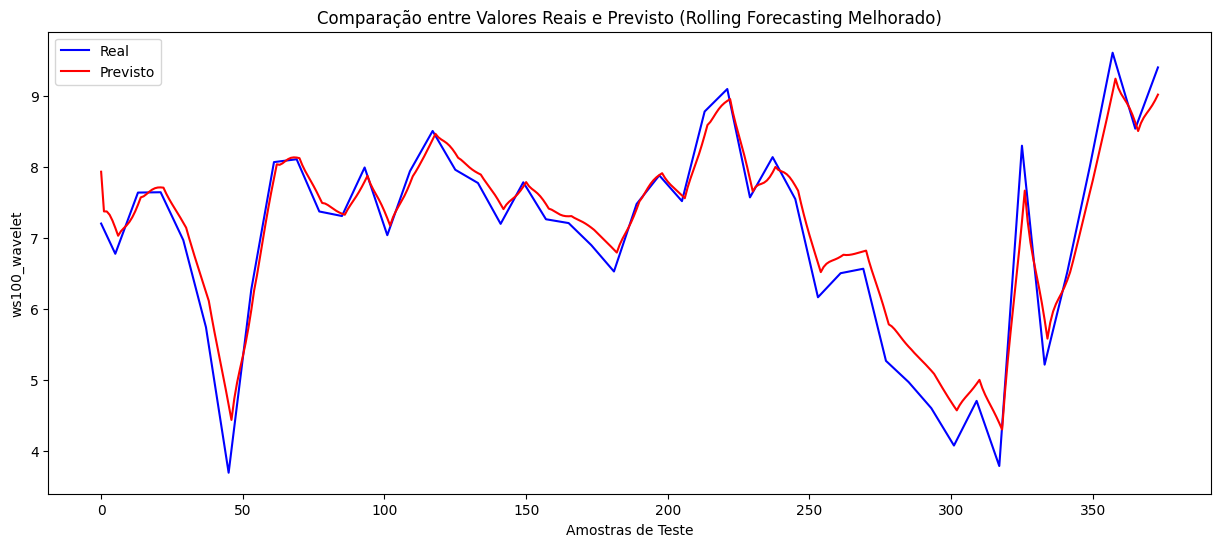

Mean Absolute Error (MAE): 0.2411
Mean Squared Error (MSE): 0.0940
Root Mean Squared Error (RMSE): 0.3066


In [18]:
# Realiza rolling forecasting simulando previsão em tempo real com feedback do decoder
predictions, actuals = rolling_forecasting_real_time_improved(
    model, 
    data_scaled=variables_scaled.values, 
    input_steps=input_steps, 
    output_steps=output_steps, 
    scaler_ws100=scaler_ws100
)

# Plotando as previsões versus os valores reais
plt.figure(figsize=(15, 6))
plt.plot(actuals, label='Real', color='blue')
plt.plot(predictions, label='Previsto', color='red')
plt.title('Comparação entre Valores Reais e Previsto (Rolling Forecasting Melhorado)')
plt.xlabel('Amostras de Teste')
plt.ylabel('ws100_wavelet')
plt.legend()
plt.show()

# Calculando e exibindo métricas de desempenho
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")